In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time, timedelta
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')  # 过滤不必要的warnings
plt.rcParams["font.sans-serif"] = ['Hiragino Sans GB']  # set font
plt.rcParams["axes.unicode_minus"] = False  # solve "-"

In [10]:
''' 基本参数 '''
list_color = ['#044E7E', '#FF3333', '#367198', '#FF8080', '#81A6BE', '#FFB2B2', '#000000', '#999999','#666633','#996633']

begin_date = '2004-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  

index_code = '000300.SH' # 沪深300代码

In [11]:
''' 数据读取函数 '''
file_path = ('/Users/15022/Desktop/算法交易/作业/M1-M2同比增速因子good/M1-M2同比增速因子/')


def load_data(file_path, df_name):
    data = pd.read_csv(f'{file_path}{df_name}.csv')
    data.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)
    data = data[begin_date: end_date]
    data.reset_index('datetime', inplace=True)
    df = pd.DataFrame(data)
    return df

In [12]:
''' 无风险利率 '''
# # wind api获取数据
# # 十年期国债收益率
# df_bond_rate = w.edb('S0059749', start_date, end_date, "", usedf=True)[1].rename(columns={'CLOSE': '中债10年国债收益率'})
# # 中债综合指数
# df_bond_index = w.wsd("CBA00201.CS", "pct_chg", start_date, end_date, "", usedf=True)[1] / 100

df_bond_rate = load_data(file_path, 'df_bond_rate')
df_bond_rate.rename(columns={'close': 'bond_close'}, inplace=True)

df_bond_index = load_data(file_path, 'df_bond_index')
df_bond_index.rename(columns={'PCT_CHG': 'bond_pct_change'}, inplace=True)

df_bond = df_bond_rate.copy()
df_bond = pd.merge(df_bond, df_bond_index[['datetime', 'bond_pct_change']], on='datetime', how='left')
df_bond.head()

datetime  bond_close  bond_pct_change
0 2004-01-02      3.1524        -0.000171
1 2004-01-05      3.8984        -0.001927
2 2004-01-06      4.2513        -0.002740
3 2004-01-07      3.7457        -0.003310
4 2004-01-08      3.8526         0.003015

In [13]:
''' 择时标的指数 '''
# # wind api获取数据
# df_stock_index = w.wsd(index_code, "close", start_date, end_date, "Days=Alldays", usedf=True)[1]

df_stock_index = load_data(file_path, 'df_stock_index')
df_stock_index.rename(columns = {'CLOSE': 'stock_close'}, inplace=True)
df_stock_index.head()

datetime  stock_close
0 2004-01-01     1194.744
1 2004-01-02     1204.613
2 2004-01-03     1204.613
3 2004-01-04     1204.613
4 2004-01-05     1240.467

In [14]:
''' 因子：M1-M2同比增速 '''
# # wind api获取数据
# dict_m_index = {'M0001383': 'M1:同比', 'M0001385': 'M2:同比'}
# list_m_index = list(dict_m_index.keys())  # M1和M2对应的代码list

# df_m_index = w.edb(list_m_index, start_date, end_date, "", usedf=True)[1].rename(columns=dict_m_index)
# df_m_index['M1-M2增速'] = df_m_index['M1:同比'] - df_m_index['M2:同比']

df_m_index = load_data(file_path, 'df_m_index')
df_m_index.head()

datetime  M1:同比  M2:同比  M1-M2增速
0 2004-01-31   15.7   18.1     -2.4
1 2004-02-29   19.8   19.4      0.4
2 2004-03-31   20.1   19.1      1.0
3 2004-04-30   20.0   19.1      0.9
4 2004-05-31   18.6   17.5      1.1

In [15]:
''' 获取开仓信号 '''
df_position = df_m_index.copy()

rolling_months = 5 # 滚动周期
df_position[f'MA-{rolling_months}'] = df_position['M1-M2增速'].rolling(rolling_months).mean()
df_position['position'] = (df_position['M1-M2增速'] >= df_position[f'MA-{rolling_months}']).astype(float)
df_position.dropna(inplace=True)

# 将月频开仓信号转换为日频
df_position_daily = df_stock_index.copy()
df_position_daily = pd.merge(df_position_daily, df_position[['datetime', 'position']], on='datetime', how='left')
df_position_daily['position'].ffill(inplace=True) 
# M1-M2数据更新滞后两周左右
df_position_daily['position'] = df_position_daily['position'].shift(12)  

df_position_daily.replace(0, -1, inplace=True)
df_position_daily.rename(columns={'stock_close': 'close'}, inplace=True)
df_position_daily = pd.merge(df_position_daily, df_bond[['datetime', 'bond_pct_change']], on='datetime', how='left')
df_position_daily.dropna(inplace=True)

df_position_daily.set_index('datetime', inplace=True)
df_position_daily.head()


close  position  bond_pct_change
datetime                                       
2004-06-14  1115.406       1.0        -0.005661
2004-06-15  1134.898       1.0         0.004883
2004-06-16  1141.093       1.0        -0.000413
2004-06-17  1116.504       1.0        -0.000384
2004-06-18  1103.403       1.0         0.003498

In [16]:
''' 计算择时净值 '''
def calculate_nav(df):
    df['index_return'] = df['close'].pct_change()
    # position为1，持有标的；position为-1，持有十年期国债
    df['timing_return'] = df['index_return'] * (df['position'].replace(-1, 0)) \
                        - df['bond_pct_change'] * (df['position'].replace(1, 0))
    df['index_nav'] = (1 + df['index_return']).cumprod()  
    df['timing_nav'] = (1 + df['timing_return']).cumprod()  
    df.dropna(inplace=True)
    return df

calculate_nav(df_position_daily).head()

close  position  bond_pct_change  index_return  timing_return  \
datetime                                                                       
2004-06-15  1134.898       1.0         0.004883      0.017475       0.017475   
2004-06-16  1141.093       1.0        -0.000413      0.005459       0.005459   
2004-06-17  1116.504       1.0        -0.000384     -0.021549      -0.021549   
2004-06-18  1103.403       1.0         0.003498     -0.011734      -0.011734   
2004-06-21  1109.391       1.0        -0.008408      0.005427       0.005427   

            index_nav  timing_nav  
datetime                           
2004-06-15   1.017475    1.017475  
2004-06-16   1.023029    1.023029  
2004-06-17   1.000984    1.000984  
2004-06-18   0.989239    0.989239  
2004-06-21   0.994607    0.994607

findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

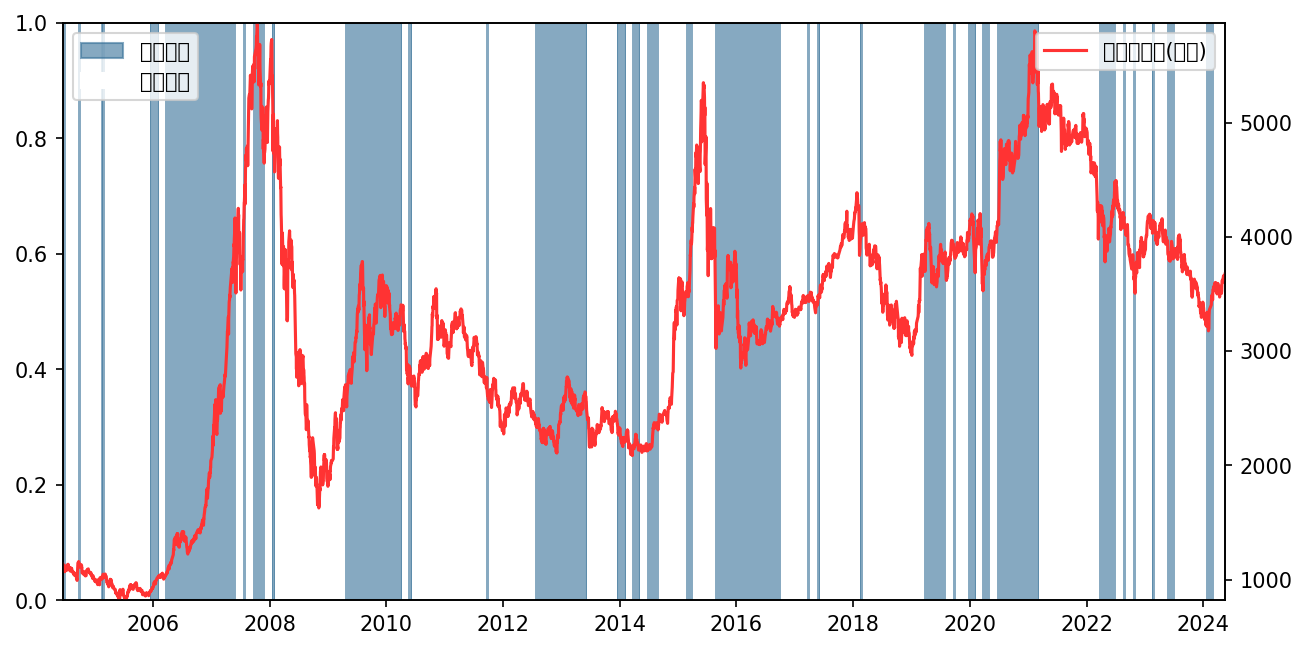

In [17]:
''' 绘制信号图 '''
def plot_signal(df):
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=150)  # 创建图形大小和分辨率。

    # 为多信号绘制蓝色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] > 0), color=list_color[2], alpha=0.6, label='做多信号')
    # 为空信号绘制绿色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] < 0), color='white', label='做空信号')
    
    ax1.set_xlim(df.index.min(), df.index.max())  # 设置x轴为DataFrame索引的最小值到最大值
    ax1.set_ylim(0, 1)  # 设置y轴的范围以容纳-1到1的信号
    
    # 绘制收盘价曲线
    ax2 = ax1.twinx()  # 创建与ax1共享x轴的ax2
    ax2.plot(df['close'], color=list_color[1], label='标的收盘价(右轴)')
    ax2.set_ylim(df['close'].min(), df['close'].max())  # 设置ax2的y轴范围以显示收盘价数据

    # 设置图例位置
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()
    plt.close() 
    
plot_signal(df_position_daily)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

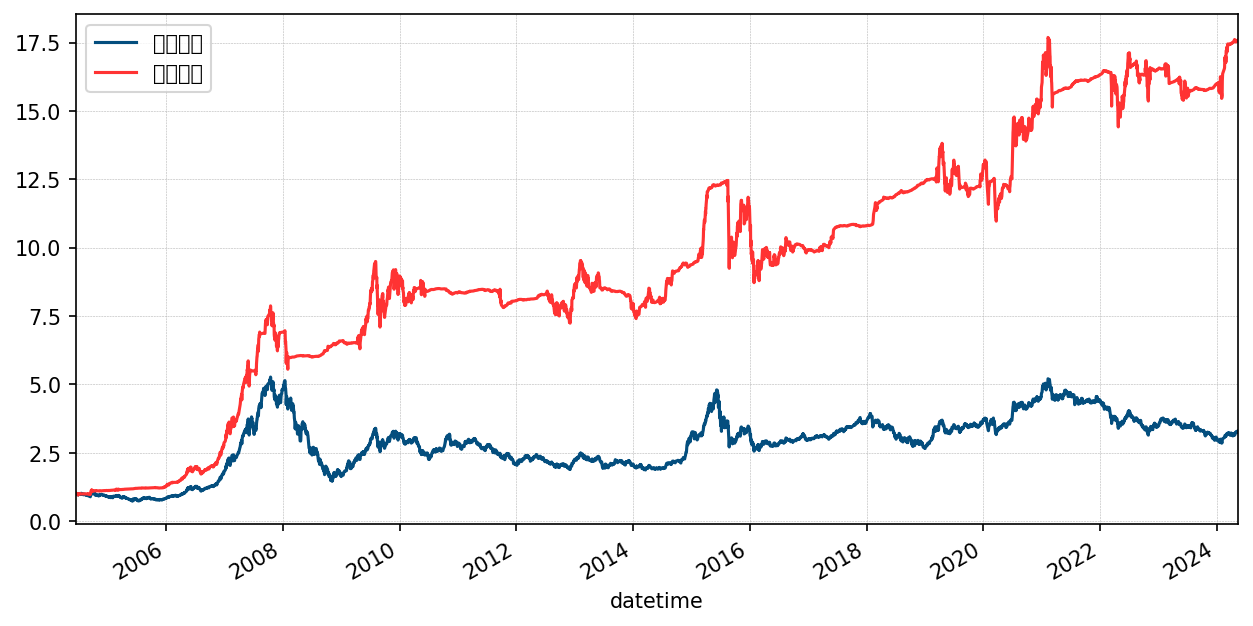

In [18]:
''' 绘制策略净值 '''
def plot_nav_curve(df):
    # 绘制策略表现
    fig = plt.figure(figsize=(10, 5), dpi=150)
    ax1 = fig.add_subplot(111)
    df[['index_nav', 'timing_nav']].plot(ax=ax1, color=list_color, legend=False)
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    legend = ax1.legend(['标的净值', '策略净值'])
    grid = ax1.grid(True, which='both', linestyle='--', linewidth=0.25)
    plt.show()
    
plot_nav_curve(df_position_daily)

In [19]:
''' 计算策略效果 '''
period = 252

def calculate_strategy_effect(df, period):
    ''' 计算年化收益 '''
    initial_nav = df['timing_nav'].iloc[0]
    final_nav = df['timing_nav'].iloc[-1]
    annual_return = (final_nav / initial_nav) ** (period / (len(df) - 1)) - 1 
    
    ''' 计算年化波动率 '''    
    annual_std = df['timing_return'].std() * np.sqrt(period)
    
    ''' 计算夏普 '''
    sharpe = annual_return / annual_std
    
    ''' 计算最大回撤 '''
    df['pre_peak'] = df['timing_nav'].cummax()
    df['maximum_drawdown'] = df['timing_nav'] / df['pre_peak'] - 1
    maximum_drawdown = df['maximum_drawdown'].min()
    return annual_return, annual_std, sharpe, maximum_drawdown

strategy_effect = calculate_strategy_effect(df_position_daily, period)

annual_return = strategy_effect[0]
annual_std = strategy_effect[1]
sharpe = strategy_effect[2]
maximum_drawdown = strategy_effect[3]

print(f'\n------------------- strategy effect ---------------------\n'
      f'annual return: {annual_return * 100:.2f}%\n'
      f'annual std: {annual_std * 100:.2f}%\n'
      f'sharpe ratio: {sharpe:.4f}\n'
      f'maximum drawdown: {maximum_drawdown * 100:.2f}%\n'
      )


------------------- strategy effect ---------------------
annual return: 16.02%
annual std: 17.02%
sharpe ratio: 0.9414
maximum drawdown: -30.02%
